In [18]:
#https://www.kaggle.com/code/skloveyyp/keras-resnet50

import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import clear_output

In [6]:
path = "../../DATA/kaggle_dsets/histopath_detection/" 
labels = pd.read_csv(path + 'train_labels.csv')
train_path = path + 'train/'
test_path = path + 'test/'

In [7]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: ((x.split("n")[2].split('.')[0])[1:]))
df = df.merge(labels, on = "id")
df.head(3)

,path,id,label
0,../../DATA/kaggle_dsets/histopath_detection/tr...,955092a572cf9bb0a1fd54d638e17e3754a77795,1
1,../../DATA/kaggle_dsets/histopath_detection/tr...,0c32f004eec2841e236f473a33254c112495c5ac,0
2,../../DATA/kaggle_dsets/histopath_detection/tr...,862c8e345d3563f5bf0b0c2ca81ee37b35b14f94,0


In [8]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

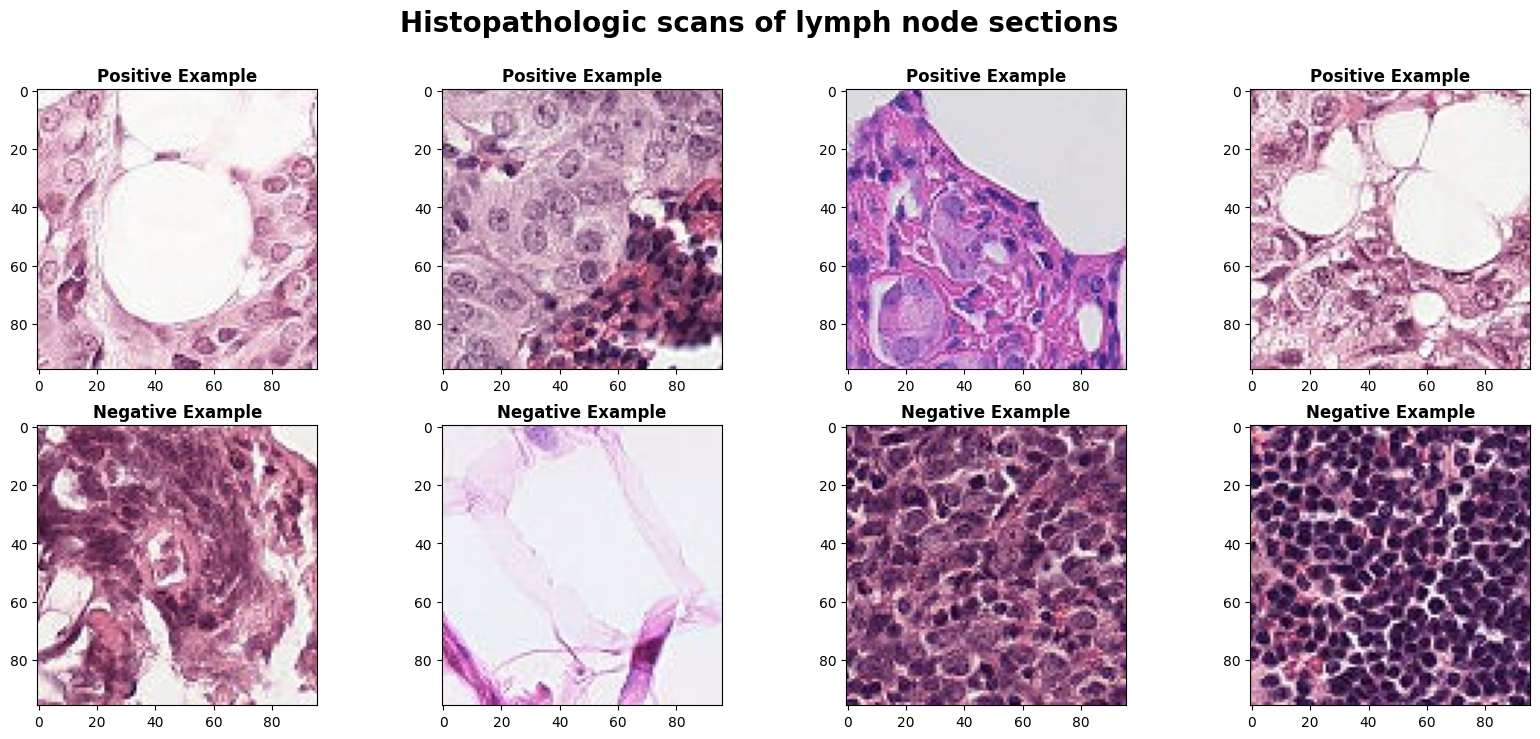

In [9]:
positive_indices = list(np.where(df["label"] == True)[0])
negative_indices = list(np.where(df["label"] == False)[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(df.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(df.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

In [10]:
IMG_SIZE = 196
BATCH_SIZE = 128

In [11]:
test_list = os.listdir(test_path)
train_list = os.listdir(train_path)
print("There are " + str(len(train_list)) + " training examples.")
print("There are " + str(len(test_list)) + " test examples.")

There are 220025 training examples.
There are 57458 test examples.


In [12]:
df['label'] = df['label'].astype(str)
train, valid = train_test_split(df, test_size=0.2, stratify = df['label'])

In [13]:
def crop_centre(image, crop_length):
    original_size = image.shape[0]
    centre = original_size // 2
    lower_bound = centre - crop_length // 2 
    upper_bound = centre + crop_length // 2
    image = image[(lower_bound):(upper_bound),(lower_bound):(upper_bound)]
    return image

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.2, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  channel_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale = 1./255) 

In [15]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (IMG_SIZE,IMG_SIZE),
                                                    class_mode = "binary",
                                                    batch_size=BATCH_SIZE,
                                                    seed = 110318,
                                                    shuffle = True)

Found 176020 validated image filenames belonging to 2 classes.


In [16]:
valid_generator = test_datagen.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False)

Found 44005 validated image filenames belonging to 2 classes.


In [19]:


dropout_fc = 0.5

conv_base = keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

2022-11-19 13:54:33.811110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 13:54:33.812100: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 2070)
2022-11-19 13:54:33.950137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 13:54:33.950232: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-11-19 13:54:33.950257: I tensorflow/core/common_runtime/pluggable_device/pluggable

In [20]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690112  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [21]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
from keras import optimizers
my_model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [23]:
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

In [24]:
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [25]:
history = my_model.fit_generator(train_generator,
                                     steps_per_epoch = train_step_size,
                                     epochs = 99,
                                     validation_data = valid_generator,
                                     validation_steps = valid_step_size,
                                     callbacks = [reduce, earlystopper],
                                     verbose = 2)


/home/lachlan/.pyenv/versions/3.7.13/envs/venv_patchcam/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10


2022-11-19 13:55:34.422632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-19 13:55:34.498600: W tensorflow/core/grappler/utils/graph_view.cc:849] No registered 'DataFormatVecPermute' OpKernel for GPU devices compatible with node {{node sequential/resnet50/pool1_pad/Pad-1-DataFormatVecPermuteNHWCToNCHW-LayoutOptimizer}}
	.  Registered:  device='XLA_CPU_JIT'; T in [DT_INT32, DT_INT64]
  device='GPU'; T in [DT_INT64]
  device='GPU'; T in [DT_INT32]
  device='XLA_CPU_JIT'; label='host'; T in [DT_INT32, DT_INT64]
  device='CPU'; label='host'; T in [DT_INT64]
  device='CPU'; label='host'; T in [DT_INT32]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]

2022-11-19 13:55:34.731253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-1

1375/1375 - 839s - loss: 0.4932 - accuracy: 0.7707 - val_loss: 0.5470 - val_accuracy: 0.7413 - lr: 0.0010 - 839s/epoch - 610ms/step
Epoch 2/10
1375/1375 - 833s - loss: 0.4670 - accuracy: 0.7848 - val_loss: 0.4781 - val_accuracy: 0.7692 - lr: 0.0010 - 833s/epoch - 606ms/step
Epoch 3/10


KeyboardInterrupt: 